**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [20]:
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
ds = LocalDataService()
## 加freq参数
start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

4.693628311157227


In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Gap30M = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

Initialize dataview success.
Initialize dataview success.


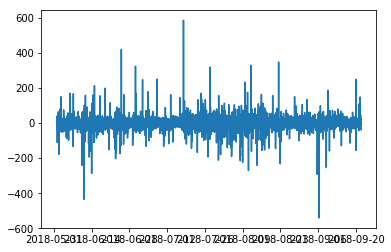

In [3]:
#30min的图
import matplotlib.pyplot as plt

plt.plot(dv30M.get_ts('gap', date_type='datetime'))
plt.show()

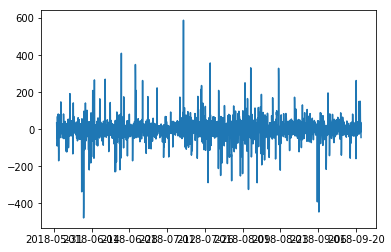

In [4]:
#1H的图
plt.plot(dv1H.get_ts('gap', date_type='datetime'))
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    # plt.savefig(chart_name)
    plt.show()

for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

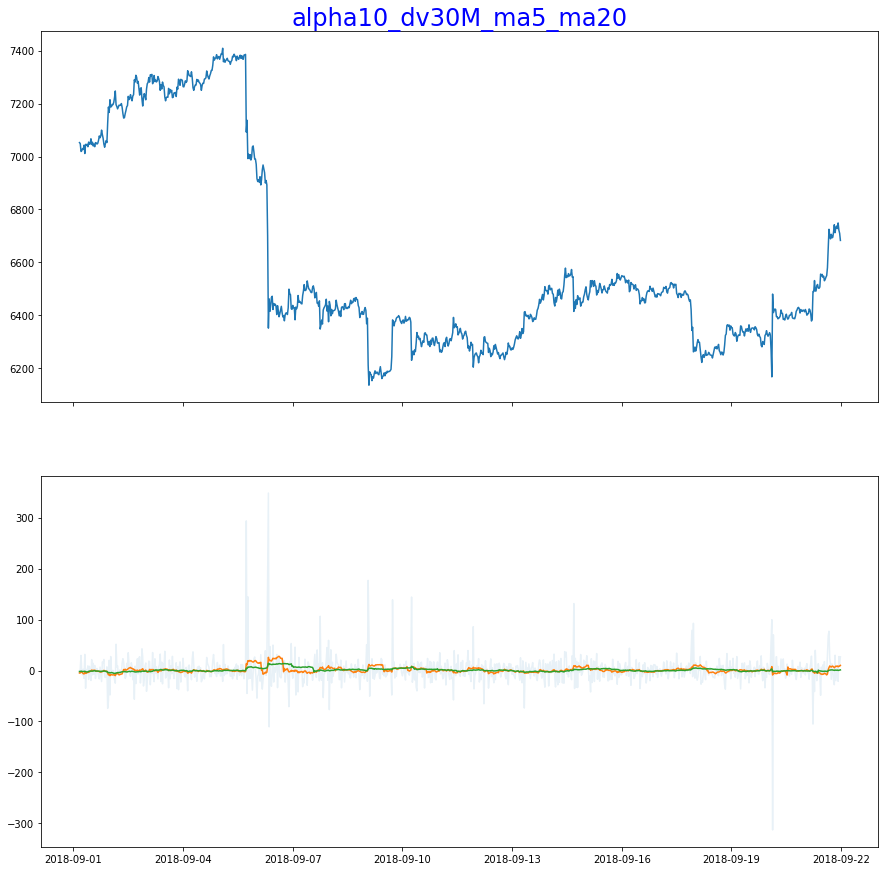

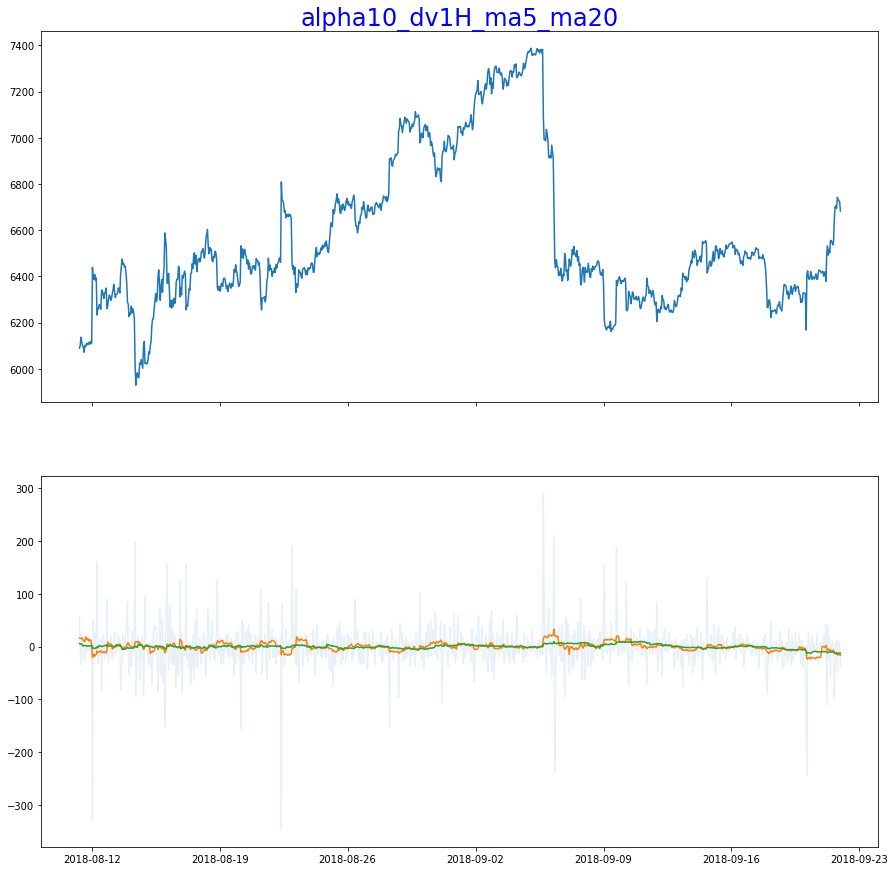

In [6]:
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',n=-1000)#橘色短线 绿色长线


In [7]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [8]:
#(sig_type="long_short")
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')

TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)
tdAlpha10.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [9]:
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


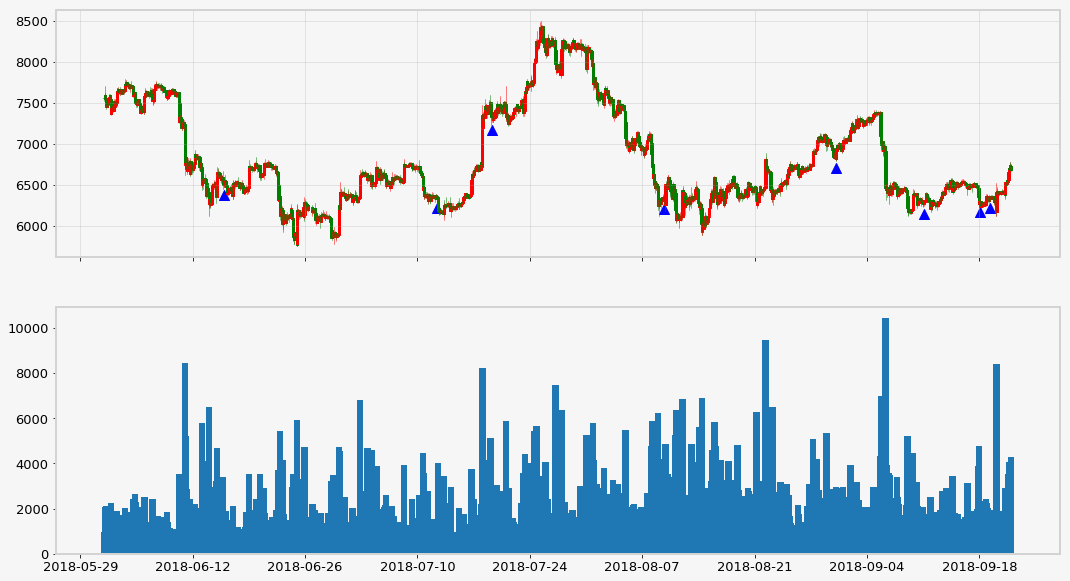

In [10]:
import matplotlib.pyplot as plt
import mpl_finance as mpf
from matplotlib.pylab import date2num

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
    
data1H = Time_dict['1H'].dropna().set_index('datetime')
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [50]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

3.99865984916687
Initialize dataview success.


In [51]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [64]:
# alpha101--alpha2
alpha2 = dv.add_formula('alpha2_C','-1*Correlation(Delta(Log(volume),2),((close-open)/open),6)',add_data=True, register_funcs={'RankPct':RankPct})

In [65]:
alpha2_plot = dv.get_ts('alpha2_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

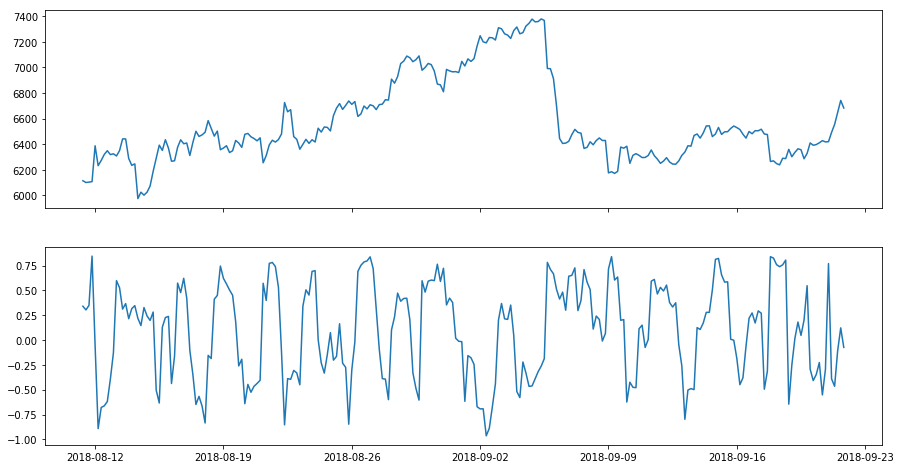

In [67]:
plot_chart(close, alpha2_plot)

#### 因子：alpha101中的alpha2
#### 现象：画图比较了股票收盘价与alpha2因子的值的关系
#### 描述：
根据alpha#002公式，我们根据公式的运算顺序解析：

1、x0 = log(volume)
逻辑结构：对成交量volume取对数操作。
解析：我们知道。取对数操作达到差异缩小的作用，使数据平稳。计量经济学经常对数据进行取对数操作。此次对成交量取对数操作的作用也是为了使数据变换成比较平稳的数据，再进行接下来的逻辑计算。

2、x1=delta(x0,2)
逻辑结构：利用当天的值x0减去过去第2天的值x0。x0为1的返回值。
解析：由1我们知道x0为取完对数操作的成交量，利用当天的x0去减过去第2天的值进行作差操作，反映当天的成交量相对于过去第2天成交量的增加或减少的量。

3、y1=(close-open)/open
逻辑结构：收盘价减开盘价的差，再除以开盘价。
解析：此式子是求当天股价的变化率的式子。反映了当天价格的变化程度。当变化率大于0时，价格上升，变化率越大价格上升程度越大；反之，价格下降。

4、x2=rank(x1)
逻辑结构：对每个股票的x1值进行排序，返回其股票对应排名的boolean值（排名所占总位数的百分比）。
解析：我们知道，x1为某只股票当天成交量相对于过去第2天成交量的增量。若增量为正，说明成交量在增加；反之，成交量在减少。对每只股票的x1进行排序，可以得到每只股票当天成交量的变化程度。即boolean值越大，某只股票的成交量增量越大。

5、y2=rank(y1)
逻辑结构：对每个股票的y2值进行排序，返回其股票对应排名的boolean值（排名所占总位数的百分比）。
解析：y1表示某只股票当天的变化率。对每只股票的变化率进行排序，可以得到每只股票当天价格的变化程度。即boolean值越大，某只股票的价格上升程度越高。

6、c=-1*correlation(x2,y2,6)
逻辑结构：计算x2和y2变量前6天的相关系数。我们知道x2和y2表示股票的排序boolean值。其计算逻辑是计算每只股票的前6天的排序boolean值的相关系数。
解析：由4和5我们知道，x2反映每只股票当天成交量的增量程度；y2反映每只股票当天价格的增量程度。
另一方面，根据相关系数的性质我们知道：
相关系数的值介于–1与+1之间，即–1≤r≤+1。其性质如下：

当r>0时，表示两变量正相关，r < 0时，两变量为负相关。
当|r| = 1时，表示两变量为完全线性相关，即为函数关系。
当r=0时，表示两变量间无线性相关关系。
当0< |r| < 1时，表示两变量存在一定程度的线性相关。且|r|越接近1，两变量间线性关系越密切；|r|越接近于0，表示两变量的线性相关越弱。
一般可按三级划分：|r|< 0.4为低度线性相关；0.4≤|r|< 0.7为显著性相关；0.7≤|r|< 1为高度线性相关。
由此，当计算的相关系数越接近1，正相关程度越大。反之，相关系数越接近-1，负相关程度越高。而对相关系数乘以-1进行取反操作，得到的alpha值。表明alpha越接近1，负相关程度越高，即股票当天成交量的增量程度与当天价格的增量程度负相关性越高。
因此，此公式是反映价量背离的规律的一个公式，买入alpha值大的股票，卖出alpha值大的股票，原理是买入加量背离程度高的股票。

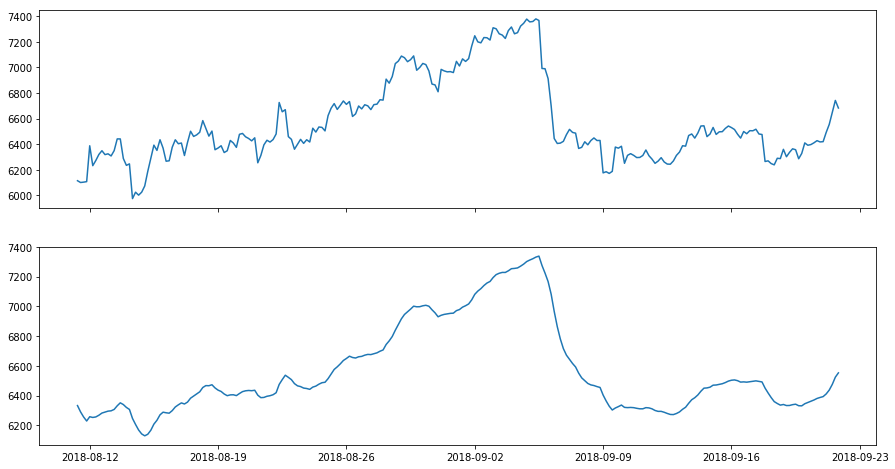

In [68]:
#EMH10
EMA10_J = dv.add_formula('EMA10_J', "Ta('EMA',0,0,0,0,close,0,10)", add_data=True)
EMA10_J_plot = dv.get_ts('EMA10_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, EMA10_J_plot)

#### 因子：技术因子中的EMA10，表示10日的移动指数平均
#### 现象：画图比较了股票收盘价与EMA10因子的值的关系
#### 描述：因子的趋势和收盘价的趋势大致一致

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [75]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

11.182546138763428
Initialize dataview success.


#### 因子1: RSI
联系：买方和卖方力量的消长会影响股票的价格。买方力量大，股票上涨；卖方力量大，股票下跌。RSI是衡量买卖双方力量强弱的指标。
进场信号：如果RSI < 30,买入，做多；或者RSI > 70 ,买入，做空
出场信号：RSI > 70,卖出，平多单；或者RSI < 30,卖出，平空单

In [87]:
#调用RSI指标
dv1H.add_formula('Ui',"If(close>Delay(close,1),close-Delay(close,1),If(close<Delay(close,1),0,0))",add_data=True)
dv1H.add_formula('Di',"If(close>Delay(close,1),0,If(close<Delay(close,1),Delay(close,1)-close,0))",add_data=True)
RSI=dv1H.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui,Ui,Ui,Ui,Ui,12)/Ta('MA',0,Di,Di,Di,Di,Di,12)))",add_data=True)
#进场信号
RSI_long = dv1H.add_formula("RSI_long","If(RSI_12<30,2,0)",add_data=True)
RSI_short = dv1H.add_formula("RSI_short","If(RSI_12>70,-2,0)",add_data=True)
#出场信号
RSI_long_close = dv1H.add_formula("RSI_long_close","If(RSI_short == -2,1,0)",add_data=True)
RSI_short_close = dv1H.add_formula("RSI_short_close","If(RSI_long == 2,-1,0)",add_data=True)

Field [Ui] is overwritten.
Field [Di] is overwritten.
Field [RSI_12] is overwritten.
Field [RSI_long] is overwritten.
Field [RSI_short] is overwritten.
Field [RSI_long_close] is overwritten.
Field [RSI_short_close] is overwritten.


In [88]:
dv1H.get_ts("RSI_long").stack()[dv1H.get_ts("RSI_long").stack()==2].head()

trade_date      symbol         
20180102020000  BTCUSDT:binance    2.0
20180106200000  BTCUSDT:binance    2.0
20180106210000  BTCUSDT:binance    2.0
20180107210000  BTCUSDT:binance    2.0
20180108010000  BTCUSDT:binance    2.0
dtype: float64

#### 因子2 MACD因子：
进场信号：上穿0轴
出场信号：下穿0轴


In [89]:
#调用MACD指标
dv1H.add_formula('MACD',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",add_data=True)
dv1H.add_formula('MACD_Signal',"Ta('EMA',0,0,0,0,MACD,0,9)",add_data=True)
dv1H.add_formula('MACD_Hist',"(MACD-MACD_Signal)",add_data=True)
#进场信号
MACD_long = dv1H.add_formula('MACD_long','If((MACD_Hist>0) && (Delay(MACD_Hist,1)<=0),2,0)',add_data = True)    
MACD_short = dv1H.add_formula('MACD_short','If((MACD_Hist<=0) && (Delay(MACD_Hist,1)>0),-2,0)',add_data = True)  
#出场信号
MACD_close_long = dv1H.add_formula('MACD_close_long','If(MACD_long == -2,1,0)',add_data = True)
MACD_close_short = dv1H.add_formula('MACD_close_short','If(MACD_short == 2,-1,0)',add_data = True)

dv1H.get_ts('MACD_long').stack()[dv1H.get_ts('MACD_long').stack()==2]
dv1H.get_ts('MACD_short').stack()[dv1H.get_ts('MACD_short').stack()==2]

Field [MACD] is overwritten.
Field [MACD_Signal] is overwritten.
Field [MACD_Hist] is overwritten.
Field [MACD_long] is overwritten.
Field [MACD_short] is overwritten.
Field [MACD_close_long] is overwritten.
Field [MACD_close_short] is overwritten.


Series([], dtype: float64)

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来
